In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
src_path = os.path.dirname(notebook_path)
sys.path.append(src_path)

import project_config.project_config
from project_config.project_config import *

In [2]:
from util.clean_abstracts import clean_abstract


print(f"SEED={SEED}")

SEED=42


In [3]:
test_abstract = '  <b><i>Background:</i></b> Little  research to date   has     investigated the spectrum of bladder health in women, including both bladder function and well-being. Therefore, we expanded our previous baseline analysis of bladder health in the Boston Area Community Health (BACH) Survey to incorporate several additional measures of bladder-related well-being collected at the 5-year follow-up interview, including one developed specifically for women. <b><i>Methods:</i></b> At follow-up, participants reported their frequency of 15 lower urinary tract symptoms (LUTS), degree of life impact from and thought related to urinary symptoms or pelvic/bladder pain/discomfort, and perception of their bladder condition. Prevalence ratios were calculated by generalized linear models with robust variance estimation, adjusting for LUTS risk factors and individual LUTS. The BACH Survey was approved by the New England Research Institutes Institutional Review Board and all participants provided written informed consent. <b><i>Results:</i></b> Generally similar findings were observed in the 5-year cross-sectional analysis as at baseline, irrespective of how we categorized LUTS or measured bladder-related well-being. Approximately one in five women (16.2%-18.0% of 2527 eligible women) reported no LUTS and no diminished bladder-related well-being, the majority (55.8%-65.7%) reported some LUTS and/or diminished well-being, and a further one in five (16.9%-26.6%) reported the maximum frequency, number, or degree of LUTS and/or diminished well-being. Measures of storage function (urinating again after <2 hours, perceived frequency, nocturia, incontinence, and urgency) and pain were independently associated with bladder-related well-being. <b><i>Conclusions:</i></b> Our similar distribution of bladder health and consistent associations between LUTS and bladder-related well-being across multiple measures of well-being, including a female-specific measure, lend confidence to the concept of a bladder health spectrum and reinforce the bothersome nature of storage dysfunction and pain.'
print(clean_abstract(test_abstract))

background little research date investigated spectrum bladder health women including bladder function wellbeing therefore expanded previous baseline analysis bladder health boston area community health bach survey incorporate several additional measures bladderrelated wellbeing collected 5year followup interview including one developed specifically women methods followup participants reported frequency 15 lower urinary tract symptoms luts degree life impact thought related urinary symptoms pelvicbladder paindiscomfort perception bladder condition prevalence ratios calculated generalized linear models robust variance estimation adjusting luts risk factors individual luts bach survey approved new england research institutes institutional review board participants provided written informed consent results generally similar findings observed 5year crosssectional analysis baseline irrespective categorized luts measured bladderrelated wellbeing approximately one five women 162180 2527 eligib

[nltk_data] Downloading package punkt to /home/dmg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dmg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Steps

# 1. Load clean abstracts and index data
# 2. Number and length of abstracts (cleaned)
# 3. Statistic description of length of abstracts
# 4. Lower threshold
# 5. Upper threshold -> downsampling
# 6. Final statistics
# 7. Final index and abstracts data
# 8. Train / Test sample

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from cmath import nan
from util.clean_abstracts import countPapers, getIndex
from sklearn.utils import resample

In [6]:
# 1. Load abstracts and index data

NAME_ABSTRACTS = "abstracts-22-05-clean"
NAME_INDEX = "index-22-05-clean"
NAME_PHEN = "phenotypes_nz_10"

PATH_ABSTRACTS_CSV = PATH_ABSTRACTS + '/' + NAME_ABSTRACTS + ".csv"
PATH_INDEX_CSV = PATH_ABSTRACTS +'/'+ NAME_INDEX + ".csv"
PATH_DATA_FENOTIPOS = PATH_PHENOTYPES + '/' + NAME_PHEN + ".csv"

dfPhen = pd.read_csv(PATH_DATA_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])
dfIndex = pd.read_csv(PATH_INDEX_CSV, sep='\t', low_memory=False, na_values=['', nan])


In [7]:
dfPapers = pd.read_csv(PATH_ABSTRACTS_CSV, sep='\t', low_memory=False, na_values=['', nan])

In [8]:
dfPapers.info()
dfIndex.info()
dfPhen.info()

m = dfIndex.shape[0]
n = dfPapers.shape[0]
print(f"Number of papers: {n}, Number of phen: {m}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2292885 entries, 0 to 2292884
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   paperId         int64 
 1   phenotypeId     object
 2   phenotypeName   object
 3   title           object
 4   clean_abstract  object
 5   length          int64 
dtypes: int64(2), object(4)
memory usage: 105.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    6107 non-null   object
 1   phenotypeName  6107 non-null   object
 2   numberPapers   6107 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 143.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       6107 non-null   object 
 1   name     6107 

In [9]:
# 2. Number and length of abstracts (raw)

dfIndex['numberPapers'].describe()

count    6107.000000
mean      375.451940
std       374.650531
min         0.000000
25%        28.000000
50%       199.000000
75%       788.000000
max      1000.000000
Name: numberPapers, dtype: float64

In [10]:
dfPapers['length'].describe()

count    2.292885e+06
mean     1.395764e+02
std      7.398649e+01
min      1.000000e+00
25%      1.010000e+02
50%      1.410000e+02
75%      1.720000e+02
max      9.279000e+03
Name: length, dtype: float64

In [11]:
# Count number of not found phenotypes
zeros = dfIndex[dfIndex.numberPapers == 0].shape[0]
print(f"Not found phenotypes:{zeros} = {zeros/m*100:.2f}%")

Not found phenotypes:309 = 5.06%


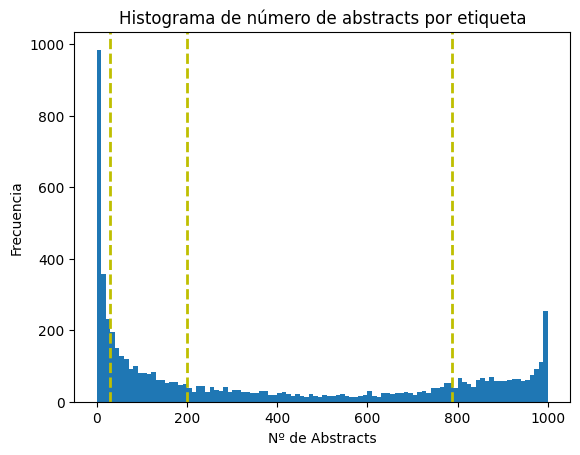

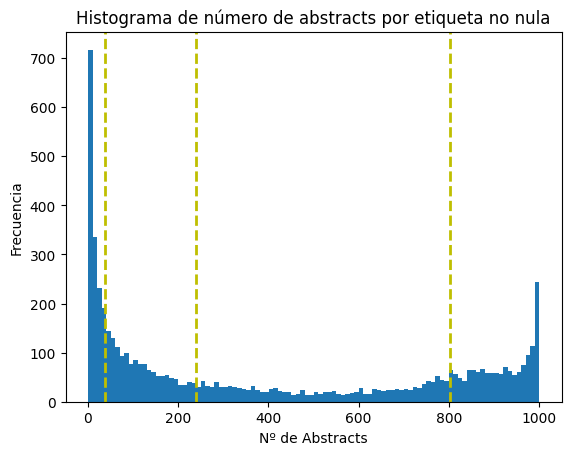

In [12]:
# Histogram for number of abstracts
dfNZ = dfIndex[dfIndex.numberPapers > 0]
plt.hist(dfIndex['numberPapers'], bins=100)

# Draw percentiles over histogram
percentiles = [0.25, 0.5, 0.75]
for p in percentiles:
    plt.axvline(dfIndex['numberPapers'].quantile(p), color='y', linestyle='dashed', linewidth=2)

plt.xlabel('Nº de Abstracts')
plt.ylabel('Frecuencia')
plt.title('Histograma de número de abstracts por etiqueta')
plt.show()

plt.hist(dfNZ['numberPapers'], bins=100)
for p in percentiles:
    plt.axvline(dfNZ['numberPapers'].quantile(p), color='y', linestyle='dashed', linewidth=2)

plt.xlabel('Nº de Abstracts')
plt.ylabel('Frecuencia')
plt.title('Histograma de número de abstracts por etiqueta no nula')
plt.show()

Mean: 139.58, Std: 73.99, Max: 9279, Min: 1


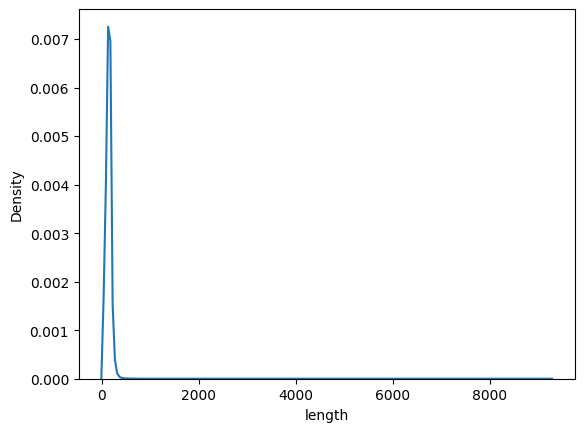

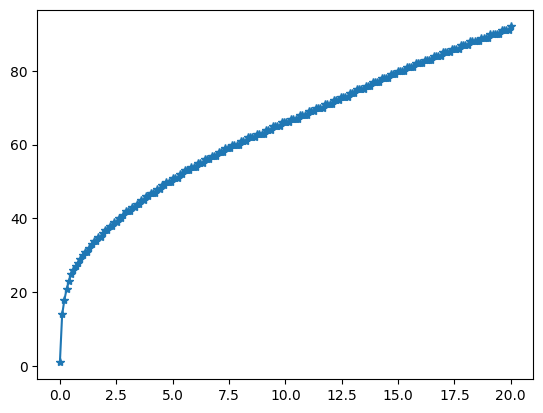

In [13]:
# Abstract length density

import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(dfPapers['length'])
mean = dfPapers['length'].mean()
std = dfPapers['length'].std()
max_ = dfPapers['length'].max()
min_ = dfPapers['length'].min()

print(f"Mean: {mean:.2f}, Std: {std:.2f}, Max: {max_}, Min: {min_}")
percentiles = np.linspace(0, 20, 200)
v = []
for p in percentiles:
    q = p/100
    y = (dfPapers['length'].quantile(q))
    v.append(y)

plt.show()

plt.plot(percentiles,v, '-*')
plt.show()

# Upper length limit: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6107 entries, 0 to 6106
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          6107 non-null   object 
 1   name        6107 non-null   object 
 2   def         5102 non-null   object 
 3   depth       6107 non-null   int64  
 4   isLeaf      6107 non-null   bool   
 5   ic          6107 non-null   float64
 6   ic_gene     6107 non-null   float64
 7   ic_omim     6107 non-null   float64
 8   descLength  5102 non-null   float64
dtypes: bool(1), float64(4), int64(1), object(3)
memory usage: 387.8+ KB


count    5102.000000
mean       19.508036
std        17.306893
min         2.000000
25%         9.000000
50%        14.000000
75%        24.000000
max       326.000000
Name: descLength, dtype: float64

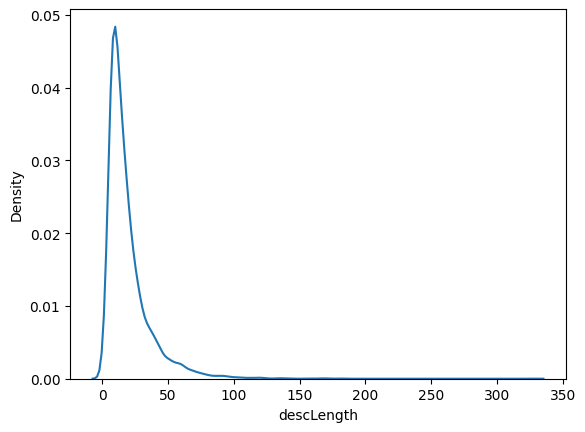

In [14]:
# Phenotype description length
import regex as re
pat = re.compile(r'"([^"]*)"([^"]*)')

def mylen(x):
    s = re.search( '"(.*)"' ,str(x))
    if s is None:
        return
    return int(len(s.group(1).split()))

dfPhen['descLength'] = dfPhen['def'].apply(lambda x : mylen(x))
dfPhen['descLength'].describe()

sns.kdeplot(dfPhen['descLength'])

dfPhen.info()
dfPhen['descLength'].describe()

In [15]:
df = dfPapers[['length', 'clean_abstract']].head()
i = 0
print(df['length'])
for index, row in df.iterrows():
    print(f"Abstract {i}: {row['length']}")
    print(row['clean_abstract'])
    i += 1

0     62
1    176
2    147
3    191
4     37
Name: length, dtype: int64
Abstract 0: 62
acromegaly results excessive secretion insulinlike growth factor1 growth hormone commonly occurs pituitary somatotrophinoma diagnostic features acromegaly include elevated insulinlike growth factor1 growth hormone lesion brain mri clinically dysmorphic features soft tissue swelling jaw prognathism acral overgrowth transsphenoidal resection primary therapy individuals acromegaly even cases gross total resection possible parasellar extension cavernous sinus involvement recurrent persistent disease resection systemic medications stereotactic radiosurgery used
Abstract 1: 176
objective acromegaly disorder caused hypersecretion growth hormone gh resulting excessive levels insulinlike growth factor 1 igf1 almost always due pituitary tumor classically associated acral enlargement prominent facial features soft tissue overgrowth skin manifestations include hirsutism acne skin tags oily skin acanthosis nigric

Count: 2290712, 99.905%


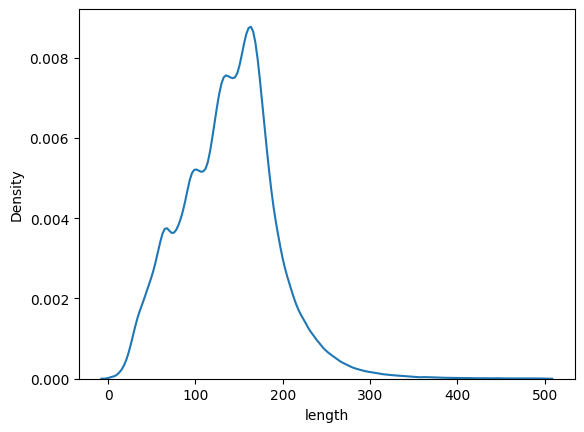

In [16]:
df2 = dfPapers[dfPapers['length'] <= 500]
count2 = df2.shape[0]
sns.kdeplot(df2['length'])
print(f"Count: {count2}, {count2/n*100:.3f}%")

* Nº abstracts: 28 < n < Me (downsample)
* Longitud: 20 < len < 1000

In [17]:
# Percentil 99.9 para longitud de abstracts
pl = 0.025
pu = 0.99905
lb = 25
ub = int(dfPapers['length'].quantile(pu))
print(f"LB: {lb}")
print(f"UB: Percentile {100*pu}% abstract length: {ub}")

LB: 25
UB: Percentile 99.905% abstract length: 500


In [18]:
# Pasos para obtener traindata
# 1. Filtro por longitud: lb = 20 <= length <= ub = 500
print("Filtrando longitud: ", lb, ub)

dfClean = dfPapers[(dfPapers['length'] >= lb) & (dfPapers['length'] <= ub)].copy()
dfIndexClean = dfNZ.copy()

countClean = dfClean.shape[0]
print(f"Abstracts escogidos: {countClean}, {countClean/n*100:.2f}%")

# nuevo index
dfIndexClean = getIndex(dfClean)
dfIndexClean.info()
print(dfIndexClean.head())
dfIndexClean['numberPapers'].describe()

Filtrando longitud:  25 500
Abstracts escogidos: 2279225, 99.40%
<class 'pandas.core.frame.DataFrame'>
Index: 5797 entries, 0 to 5796
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    5797 non-null   object
 1   numberPapers   5797 non-null   int64 
 2   phenotypeName  5797 non-null   object
dtypes: int64(1), object(2)
memory usage: 181.2+ KB
  phenotypeId  numberPapers                 phenotypeName
0  HP:0000003           666  Multicystic kidney dysplasia
1  HP:0000011           844            Neurogenic bladder
2  HP:0000012           984               Urinary urgency
3  HP:0000013           785      Hypoplasia of the uterus
4  HP:0000016           762             Urinary retention


count    5797.000000
mean      393.173193
std       372.084394
min         1.000000
25%        39.000000
50%       239.000000
75%       798.000000
max      1000.000000
Name: numberPapers, dtype: float64

LB: 39.0, ME: 239.0


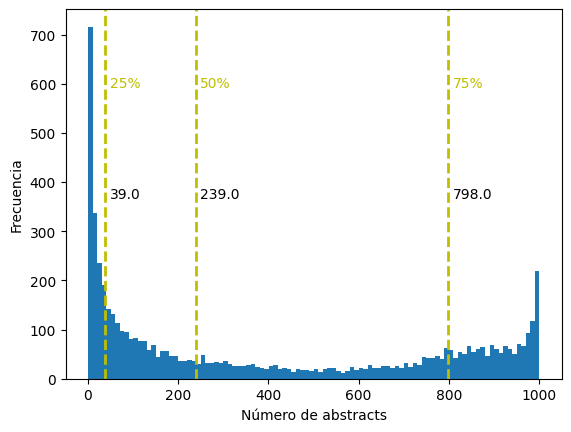

In [19]:
# 2. Filtro por nº abstracts por fenotipo: q_25 <= numberPapers <= Me (downsample)

plt.hist(dfIndexClean['numberPapers'], bins=100)

# Draw percentiles over histogram
percentiles = [0.25, 0.5, 0.75]
for p in percentiles:
    val = dfIndexClean['numberPapers'].quantile(p)
    plt.axvline(val, color='y', linestyle='dashed', linewidth=2)
    plt.text(val+10, plt.ylim()[1]*0.5, f'{val:.1f}', color='black', rotation=0, verticalalignment='center')
    plt.text(val+10, plt.ylim()[1]*0.8, f'{100*p:.0f}%', color='y', rotation=0, verticalalignment='center')
lb = dfIndexClean['numberPapers'].quantile(0.25)
me = dfIndexClean['numberPapers'].median()

plt.xlabel('Número de abstracts')
plt.ylabel('Frecuencia')
#plt.title('Histograma de número de abstracts por fenotipo (tras filtrado por longitud).')

print(f"LB: {lb}, ME: {me}")

In [20]:
# filtro por abajo
dfIndexClean = dfIndexClean[dfIndexClean['numberPapers'] >= lb]
dfClean = dfClean[dfClean['phenotypeId'].isin(dfIndexClean['phenotypeId'])]
dfIndexClean.info()
dfClean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4358 entries, 0 to 5796
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4358 non-null   object
 1   numberPapers   4358 non-null   int64 
 2   phenotypeName  4358 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2259879 entries, 22 to 2292884
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   paperId         int64 
 1   phenotypeId     object
 2   phenotypeName   object
 3   title           object
 4   clean_abstract  object
 5   length          int64 
dtypes: int64(2), object(4)
memory usage: 120.7+ MB


In [21]:
# 3. Downsampling

dfDown = pd.DataFrame()

for index, row in dfIndexClean.iterrows(): # For each phenotype
    n = row['numberPapers']
    dfAux = dfClean[dfClean['phenotypeId'] == row['phenotypeId']]
    if n > me:
        # get random sample of size n-Me
        df = resample(dfAux, replace=False, n_samples=int(me), random_state=SEED)
        # add it to new dataframe
        dfDown = pd.concat([dfDown, df])
    else:
        dfDown = pd.concat([dfDown, dfAux])


dfClean = dfDown
dfIndexClean = getIndex(dfClean)
dfIndexClean.info()
dfClean.info()        

<class 'pandas.core.frame.DataFrame'>
Index: 4358 entries, 0 to 4357
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4358 non-null   object
 1   numberPapers   4358 non-null   int64 
 2   phenotypeName  4358 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 859901 entries, 484522 to 840924
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   paperId         859901 non-null  int64 
 1   phenotypeId     859901 non-null  object
 2   phenotypeName   859901 non-null  object
 3   title           859901 non-null  object
 4   clean_abstract  859901 non-null  object
 5   length          859901 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 45.9+ MB


In [22]:
dfIndexClean.describe()

,numberPapers
count,4358.000000
mean,197.315512
std,67.184100
min,39.000000
25%,156.000000
50%,239.000000
75%,239.000000
max,239.000000


Phenotypes with less than 239.0 abstracts: 1459, 33.48%


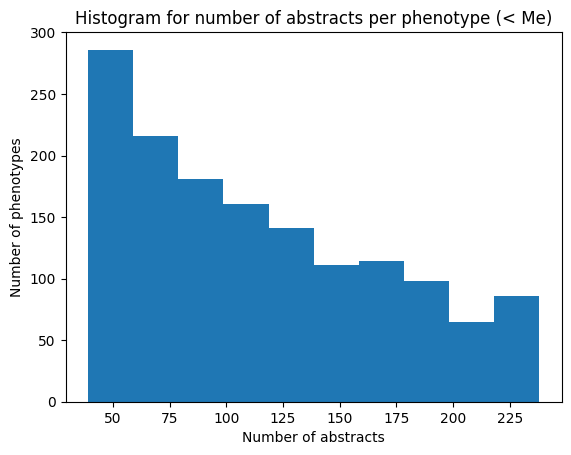

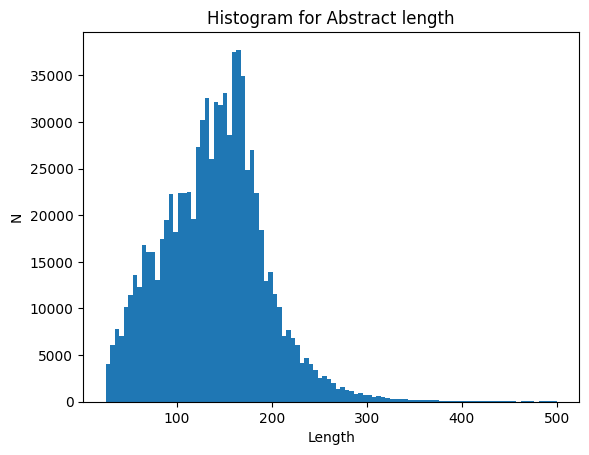

In [23]:
# 4. Final statistics
dfLower = dfIndexClean[dfIndexClean['numberPapers'] < me]
perc = dfLower.shape[0]/dfIndexClean.shape[0]*100
print(f"Phenotypes with less than {me} abstracts: {dfLower.shape[0]}, {perc:.2f}%")
plt.hist(dfLower['numberPapers'])
plt.title("Histogram for number of abstracts per phenotype (< Me)")
plt.xlabel("Number of abstracts")
plt.ylabel("Number of phenotypes")
plt.show()

plt.hist(dfClean['length'], bins=100)
plt.title("Histogram for Abstract length")
plt.xlabel("Length")
plt.ylabel("N")
plt.show()

In [25]:
# 5. Test / Train sample
# 400 NZ phenotypes left out for STS evaluation

dfPhen = pd.read_csv(PATH_DATA_FENOTIPOS, sep='\t', low_memory=False, na_values=['', nan])
testPhen = dfPhen.sample(n=400, random_state=SEED) # 400 phenotypes for test, not cleaned
testPhen = testPhen[['id', 'name']]
dfAbstractsTrain = dfClean[~dfClean['phenotypeId'].isin(testPhen['id'])]
dfIndexTrain = getIndex(dfAbstractsTrain)

left = dfIndexClean.shape[0] - dfIndexTrain.shape[0]
print(f"Phenotypes: Test - {testPhen.shape[0]} ; Train - {dfIndexTrain.shape[0]}; Left - {left}")

dfAbstractsTrain.info()
dfIndexTrain.info()
testPhen.info()

Phenotypes: Test - 400 ; Train - 4070; Left - 288
<class 'pandas.core.frame.DataFrame'>
Index: 802664 entries, 484522 to 1801893
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   paperId         802664 non-null  int64 
 1   phenotypeId     802664 non-null  object
 2   phenotypeName   802664 non-null  object
 3   title           802664 non-null  object
 4   clean_abstract  802664 non-null  object
 5   length          802664 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 42.9+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 4070 entries, 0 to 4069
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   phenotypeId    4070 non-null   object
 1   numberPapers   4070 non-null   int64 
 2   phenotypeName  4070 non-null   object
dtypes: int64(1), object(2)
memory usage: 127.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 13

In [33]:
# 6. Save data
import datetime
from datetime import datetime

s = datetime.today().strftime('%d-%m')


PATH_ABSTRACTS_TRAIN = PATH_DATA + '/abstracts/' + "abstracts-" + s + "-train.csv"
PATH_INDEX_TRAIN = PATH_DATA + '/phenotypes/' + "index-" + s + "-train.csv"
PATH_INDEX_TEST = PATH_DATA + '/phenotypes/' + "index-" + s + "-test.csv"

dfAbstractsTrain.to_csv(PATH_ABSTRACTS_TRAIN, sep='\t', index=False)
dfIndexTrain.to_csv(PATH_INDEX_TRAIN, sep='\t', index=False)
testPhen.to_csv(PATH_INDEX_TEST, sep='\t', index=False)

In [34]:
# 7. Train / test pairs
from datetime import datetime

s = datetime.today().strftime('%d-%m')

import math
import random
from itertools import combinations
import bisect

# get all combinations of test phenotypes

testNames = testPhen['name'].tolist()
pairs = list(combinations(testNames, 2))

from pyhpo import Ontology

# Load ontology

onto = Ontology(PATH_ONTO)

def onto_sim(name1, name2):
    phen1 = onto.get_hpo_object(name1)
    phen2 = onto.get_hpo_object(name2)
    v = phen1.similarity_score(phen2, method='lin')
    sim = min(v,1)
    return sim

ltest1, ltest2 = zip(*pairs)
goldTest = [onto_sim(pair[0], pair[1]) for pair in pairs]

dfTest = pd.DataFrame({'phenotype1': ltest1, 'phenotype2': ltest2, 'lin': goldTest})
dfTest.to_csv(PATH_EVALUATION + '/test_pairs-' + s + '.csv', sep='\t', index=False)


In [39]:
random.seed(SEED)
def random_combinations(iterable, k, size):
    "Sample n=size combinations of k elements from iterable without replacement."
    pool = tuple(iterable)
    n = len(pool)
    m = (math.comb(n,k))
    codes = random.sample(range(m), size)
    l = list()
    # Given j=code, get the j-th combination
    for code in codes:
        indices = np.array([], dtype=int)
        j = code
        for i in range(k):
            q, r = divmod(j, n-i)
            index = bisect.bisect_right(indices, r)
            r = r + index
            indices = np.insert(indices, index, r)
            j = q
        l.append(pool[i] for i in list(indices)) 
    return l

# Example
k = 2
size = 5000
l = random_combinations(dfIndexTrain['phenotypeName'], k, size)
df = pd.DataFrame(l, columns=['phenotype'+str(i) for i in range(1,k+1)])
print(df.head())

                      phenotype1                             phenotype2
0  Decreased numbers of nephrons         Decreased mitochondrial number
1                   Narrow chest               Fasting hyperinsulinemia
2               Median cleft lip                            High myopia
3       Adrenocortical carcinoma  Inferior cerebellar vermis hypoplasia
4                 Hypercalciuria                    Howell-Jolly bodies


In [41]:
k = 2
size = 5000

lTrain = list(random_combinations(dfIndexTrain['phenotypeName'], k, size))
lTrain1, lTrain2 = zip(*lTrain)

goldTrain = []
for i in range(size):
    g = onto_sim(lTrain1[i], lTrain2[i])
    goldTrain.append(g)

dfTrain = pd.DataFrame({'phenotype1': lTrain1, 'phenotype2': lTrain2, 'lin': goldTrain})

dfTrain.to_csv(PATH_EVALUATION + '/train_pairs-' + s + '.csv', sep='\t', index=False)

In [42]:
lTest = list(random_combinations(testPhen['name'], k, size))
lTest1, lTest2 = zip(*lTest)

goldTest = []
for i in range(size):
    g = onto_sim(lTest1[i], lTest2[i])
    goldTest.append(g)

dfTest = pd.DataFrame({'phenotype1': lTest1, 'phenotype2': lTest2, 'lin': goldTest})
dfTest.to_csv(PATH_EVALUATION + '/test_pairs-' + s + '.csv', sep='\t', index=False)

Lin train distribution:
count    5000.000000
mean        0.025734
std         0.081302
min         0.000000
25%         0.000045
50%         0.000050
75%         0.000065
max         1.000000
Name: lin, dtype: float64
Lin test distribution:
count    5000.000000
mean        0.026155
std         0.078252
min         0.000000
25%         0.000043
50%         0.000048
75%         0.000087
max         0.886559
Name: lin, dtype: float64


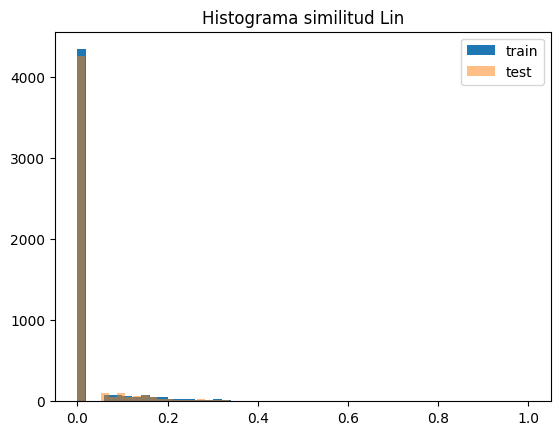

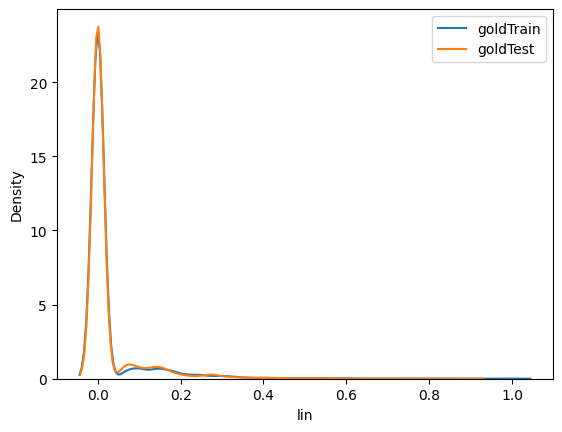

Var Train: 0.006608668104869113
Train score 0-model MSE: 0.007270885399127182
Var Test: 0.006122182401058843
Test score 0-model MSE: 0.006806252548159972


In [4]:
import scipy

SAVED=True
s='31-05'
if SAVED:
    dfTrain = pd.read_csv(PATH_EVALUATION + '/train_pairs-' + s + '.csv', sep='\t', low_memory=False, na_values=['', nan])
    dfTest = pd.read_csv(PATH_EVALUATION + '/test_pairs-' + s + '.csv', sep='\t', low_memory=False, na_values=['', nan])

# Dibujar la distribución de gold train

print("Lin train distribution:")
print(dfTrain['lin'].describe())
# Dibujar la distribución de gold test

print("Lin test distribution:")
print(dfTest['lin'].describe())

plt.hist(dfTrain['lin'], bins=50, label='train')
plt.hist(dfTest['lin'], bins=50, label='test', alpha=0.5)
plt.legend()
plt.title('Histograma similitud Lin')
plt.show()

import seaborn as sns

sns.kdeplot(dfTrain['lin'], label='goldTrain')
sns.kdeplot(dfTest['lin'], label='goldTest')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

print("Var Train:", np.var(dfTrain['lin']))
print("Train score 0-model MSE:", np.mean(dfTrain['lin'].apply(lambda x : x*x)))
print("Var Test:", np.var(dfTest['lin']))
print("Test score 0-model MSE:", np.mean(dfTest['lin'].apply(lambda x : x*x)))


In [8]:
# Estimación de un MARGIN:
# muestra de pares de train: mínima distancia coseno entre dos fenotipos train para el modelo inicial



In [9]:
import sentence_transformers as strans
from sentence_transformers import SentenceTransformer

model = SentenceTransformer(PRITAMDEKAMODEL) # Original

/home/dmg/.conda/envs/bert_3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

e1 = model.encode(dfTrain['phenotype1'])
e2 = model.encode(dfTrain['phenotype2'])
similarities = cosine_similarity(e1, e2)


In [11]:
sims = [similarities[i][i] for i in range(len(similarities))]

<Axes: ylabel='Density'>

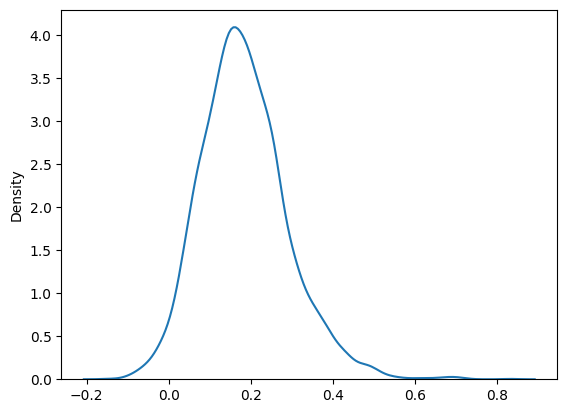

In [12]:
sns.kdeplot(sims, label='cosOriginal')

In [13]:
dfTrain['cos'] = sims
dfTrain['cos'].describe()

count    5000.000000
mean        0.183506
std         0.105870
min        -0.149243
25%         0.112616
50%         0.175031
75%         0.245513
max         0.833796
Name: cos, dtype: float64

In [14]:
margin = 1-dfTrain['cos'].quantile(0.9)
print(f"MARGIN estimado 1 (cos) = {margin}")

MARGIN estimado = 0.6828944981098175


In [7]:
margin2 = 1-dfTrain['lin'].quantile(0.9)
print(f"MARGIN estimado 2 (lin) = {margin2}")

MARGIN estimado 2 (lin) = 0.8974102111928584


In [16]:
s = '31-05'
dfTrain.to_csv(PATH_EVALUATION + '/train_pairs-' + s + '.csv', sep='\t', index=False)